# Clean train Data

In [1]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

In [3]:
# read data in memory
#data = pd.read_csv("C:\\Users\\Leo\\TaxiData\\train.csv",index_col=0)
data = pd.read_csv("train.csv")

In [4]:
data.RatecodeID.value_counts()

1     10815797
2       255270
5        36270
3        22195
4         5549
99         272
6          117
Name: RatecodeID, dtype: int64

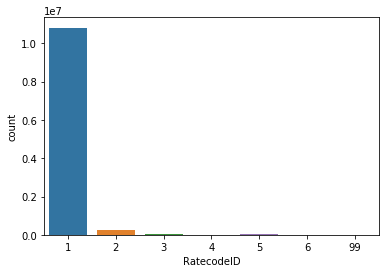

In [5]:
sns.countplot(data.RatecodeID)

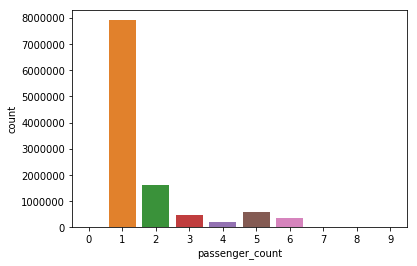

In [6]:
sns.countplot(data.passenger_count)

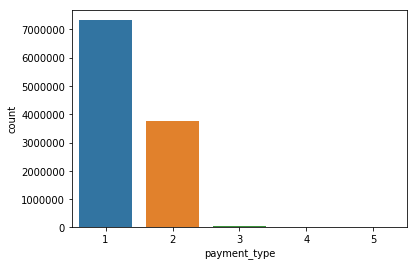

In [7]:
sns.countplot(data.payment_type)

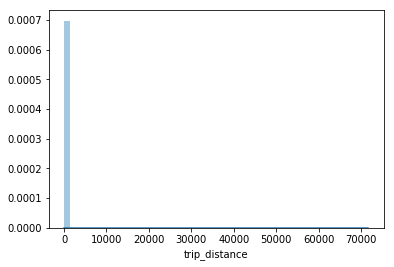

In [8]:
sns.distplot(data.trip_distance)

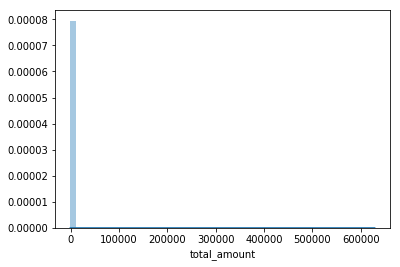

In [9]:
sns.distplot(data.total_amount)

## Obvious invalid values

Clean the data.
Remove all obvious outliers:
* Invalid Ratecoded (must be in range 1,2,3,4,5,6)
* Invalid improvement_surcharge (only .3 is valid!)
* Invalid mta_tax (either 0 or .5)
* Invalid extra (0,0.5,1,1.5,4.5)
* All negative values (costs can't be negative!)
* Drop useless information
    * store_and_fwd_flag (Useless)
    * Vendor ID (Useless)
    * Improvement surcharge (Fixed value!)
* Calculate total amount, drop outliers (values which doesnt equal to the total amount must be wrong!)
* Save pickup and dropoff time as datetime object

In [72]:
print(df.shape)
# Drop all data with invalid extra, improvement_surcharge, RatecodeID, mta_tax -> Invalid!
df = data.drop(data[data.extra.isin([0,0.5,1,1.5,4.5]) == False].index)
print(df.shape)
df = df.drop(df[df.improvement_surcharge!=0.3].index)
print(df.shape)
# Also drop 6 -> No group rides in test data!
df = df.drop(df[df.RatecodeID.isin([1,2,3,4,5]) == False].index)
print(df.shape)
df = df.drop(df[df.mta_tax.isin([0,0.5]) == False].index)
print(df.shape)

df = df.drop(df[df.tip_amount < 0].index)
df = df.drop(df[df.fare_amount <= 0].index)
df = df.drop(df[df.total_amount <= 0].index)
df = df.drop(df[df.tolls_amount < 0].index)
df = df.drop(df[df.pickup_latitude == 0].index)
df = df.drop(df[df.pickup_longitude == 0].index)
df = df.drop(df[df.dropoff_latitude == 0].index)
df = df.drop(df[df.dropoff_longitude == 0].index)
print(df.shape)

(11128037, 19)
(11133123, 19)
(11128278, 19)
(11128037, 19)
(11128037, 19)
(10973256, 19)


In [73]:
df.RatecodeID.value_counts()

1    10670060
2      249517
5       26576
3       21660
4        5443
Name: RatecodeID, dtype: int64

In [74]:
data.RatecodeID.value_counts()

1     10815797
2       255270
5        36270
3        22195
4         5549
99         272
6          117
Name: RatecodeID, dtype: int64

In [75]:
# Drop useless columns
df = df.drop(['VendorID','store_and_fwd_flag','improvement_surcharge'],axis=1)

In [76]:
df.groupby(['RatecodeID']).mta_tax.value_counts()
#ax = df.groupby(['RatecodeID']).mta_tax.value_counts().plot(kind='bar', figsize=(15, 5))
#ax.set_xlabel('RatecodeID', fontsize=18)
#ax.set_ylabel('Number of trips', fontsize=18)
#ax.tick_params(labelsize=12)

RatecodeID  mta_tax
1           0.5        10668433
            0.0            1627
2           0.5          249400
            0.0             117
3           0.0           21655
            0.5               5
4           0.5            5443
5           0.0           19588
            0.5            6988
Name: mta_tax, dtype: int64

In [77]:
# drop invalid rush hour surtaxes
df = df.drop(df[(df.RatecodeID !=2) & ((df.extra.isin([0,0.5,1,1.5]))==False)].index)
df = df.drop(df[(df.RatecodeID ==2) & ((df.extra.isin([0,4.5]))==False)].index)
df = df.drop(df[(df.RatecodeID ==3) & (df.mta_tax == .5)].index)
df = df.drop(df[(df.RatecodeID.isin([1,2,4])) & (df.mta_tax == 0)].index)

# Rush Hour on Weekends
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.weekday>=5)].index)
# Rush Hour picked up after 20
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)].index)
# Rush Hour dropped before 16
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 16)].index)
# Overnight picked up after 6 and dropped before 20
df = df.drop(df[(df.extra == 0.5) & \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 6) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20))].index)

# Remove Dependant on Ratecode invalid data
# All price steps are in 0.5! (excluding negotiated)
df = df.drop(df[(df.RatecodeID !=5) & ((df.fare_amount%0.5)!=0)].index)
df = df.drop(df[(df.RatecodeID ==2) & ((df.fare_amount!=52))].index)
df = df.drop(df[(df.RatecodeID ==3) & ((df.fare_amount<=20))].index)
df = df.drop(df[(df.RatecodeID.isin([1,4,5])) & ((df.fare_amount<3))].index)

# Remove values where total isnt the sum of all
total = df.extra+df.tip_amount+df.tolls_amount+df.mta_tax+df.fare_amount + 0.3
df = df.drop(df[df.total_amount != total].index)

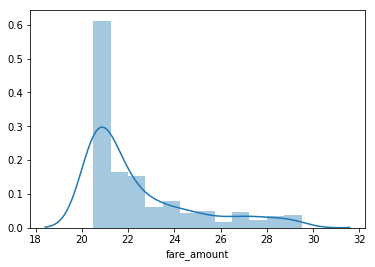

In [78]:
sns.distplot(df[(df.RatecodeID == 3) & (df.fare_amount < 30)].fare_amount)

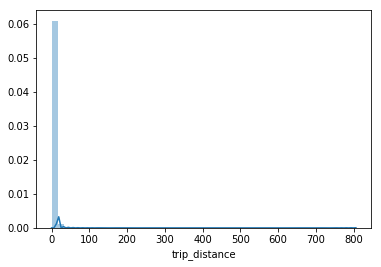

In [79]:
sns.distplot(df.trip_distance)

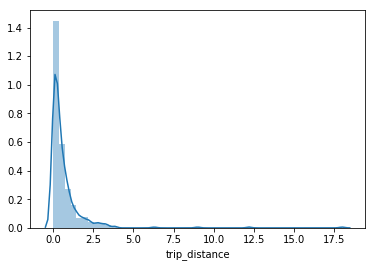

In [80]:
sns.distplot(df[(df.RatecodeID == 3) & (df.fare_amount < 30)].trip_distance)

In [81]:
df[(df.RatecodeID == 3) & (df.fare_amount < 30)].trip_distance.describe()

count    449.000000
mean       0.675479
std        1.304531
min        0.000000
25%        0.100000
50%        0.310000
75%        0.800000
max       18.000000
Name: trip_distance, dtype: float64

In [82]:
df = df.drop(df[df.tolls_amount > 30].index)

df = df.drop(df[df.fare_amount > 400].index)

df = df.drop(df[(df.fare_amount > 80)&(df.RatecodeID==1)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==2)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==3)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==4)].index)
df = df.drop(df[(df.fare_amount > 400)&(df.RatecodeID==5)].index)



df = df.drop(df[(df.passenger_count < 1) | (df.passenger_count > 6)].index)

In [83]:
#removing outliers (far away from manhattan)
manLat = 40.756716
manLong = -73.985368
margin = 1

print("With outliers:",np.shape(df))
df = df.loc[(abs(df["dropoff_latitude"]-manLat)<margin) 
                   &(abs(df["pickup_latitude"]-manLat)<margin) 
                   &(abs(df["dropoff_longitude"]-manLong)<margin) 
                   &(abs(df["pickup_longitude"]-manLong)<margin)]
print("Without outliers:",np.shape(df))

With outliers: (9111143, 16)
Without outliers: (9110879, 16)


Transform datetime in datetime objects

In [84]:
df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [85]:
# Get duration
df['duration'] = (pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"]))\
    .astype('timedelta64[s]')

In [86]:
#drop all negative and too short rides  (< 30s , 40s is lowest in test data!)
df = df.drop(df[df.duration < 30].index)

# drop all > 3h (unreasonable long, 2:30 is longest in test data)
df = df.drop(df[df.duration > 3*3600].index)

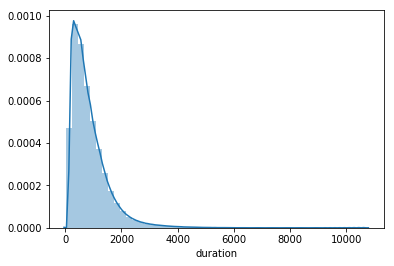

In [87]:
sns.distplot(df.duration)

df.info()

In [88]:
df.RatecodeID.value_counts()

1    8921542
2     128732
3      17522
5      15415
4       3558
Name: RatecodeID, dtype: int64

# Add new Attributes

In [89]:
# Calculate subtotal
df['subtotal'] = df.total_amount - df.tip_amount

# Calculating the tip percentage.
df['tip_perc'] = (df.tip_amount / df.subtotal)

df['duration'] = pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"])

df['duration'] = df.duration.dt.total_seconds()


df['pickup_hour'] = pd.to_datetime(df.tpep_pickup_datetime).dt.hour.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')

df['pickup_coord']=list(zip(df.pickup_latitude, df.pickup_longitude))
df['dropoff_coord']=list(zip(df.dropoff_latitude, df.dropoff_longitude))

# Calulcate avg speed (mph)
df['avg_speed'] = (df.trip_distance)/(df.duration/3600)

In [91]:
#Clean
c = df.avg_speed.count()
df = df.drop(df[(df.trip_distance < 0.1) | (df.trip_distance > 100) ].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Unreasonable trip distance)")
c = df.avg_speed.count()
df = df.drop(df[(df.avg_speed < 0.5) | (df.avg_speed > 80) ].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Unreasonable speed)")
c = df.avg_speed.count()
df = df.drop(df[(df.tip_perc > .5 ) & df.tip_amount > 5].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Huge tip)")


Dropped  17797  Elements (Unreasonable trip distance)
Dropped  1932  Elements (Unreasonable speed)
Dropped  0  Elements (Huge tip)


In [93]:
# Get Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = pd.date_range(start=df['tpep_pickup_datetime'].min(), end=df['tpep_pickup_datetime'].max())
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['tpep_pickup_datetime'].isin(holidays)

In [96]:
df['overnight'] = \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour <= 5) | \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)

In [97]:
df['day'] = (pd.to_datetime(df['tpep_pickup_datetime']).dt.weekday_name)

In [98]:
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour <= 5) | \
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 20) |  \

df['overnight'] = \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour <= 5) | \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9067040 entries, 0 to 11135469
Data columns (total 26 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               category
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
total_amount             float64
duration                 float64
subtotal                 float64
tip_perc                 float64
pickup_hour              category
pickup_coord             object
dropoff_coord            object
avg_speed                float64
holiday                  bool
overnight                bool
day                      object
dtypes: bool(2), category

# Check if data makes sense now

In [ ]:
df.describe()

In [ ]:
df.trip_distance.max()

# Check Test Data

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.payment_type.value_counts()

In [ ]:
test[test.trip_distance > 30].RatecodeID.value_counts()

In [ ]:
test.improvement_surcharge.value_counts()

In [ ]:
test.passenger_count.value_counts()

In [ ]:
test.pickup_latitude.value_counts()

In [ ]:
#removing outliers (far away from manhattan)
manLat = 40.756716
manLong = -73.985368
margin = 1.0

print("With outliers:",np.shape(test))
test2 = test.loc[(abs(test["dropoff_latitude"]-manLat)<margin) 
                   &(abs(test["pickup_latitude"]-manLat)<margin) 
                   &(abs(test["dropoff_longitude"]-manLong)<margin) 
                   &(abs(test["pickup_longitude"]-manLong)<margin)]
print("Without outliers:",np.shape(test2))

In [ ]:
test.loc[(abs(test["dropoff_latitude"]-manLat)<margin) 
                   &(abs(test["pickup_latitude"]-manLat)<margin) 
                   &(abs(test["dropoff_longitude"]-manLong)>margin) 
                   &(abs(test["pickup_longitude"]-manLong)<margin)]

# Save

In [ ]:
#df.to_csv('C:\\Users\\Leo\\TaxiData\\clean.csv', index=False)

In [ ]:
df.to_csv('clean.csv', index=True)